In [5]:
import numpy as np
import random
import json
import os
from PIL import Image, ImageOps, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# summarize controller parameters

from models.vae import VAE 
from models.controller import Controller
from torchsummary import summary

input_size = 32 + 13
output_size = 13

model = Controller(input_size, output_size).cuda()
summary(model, (1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 13]             598
Total params: 598
Trainable params: 598
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
# convert ic/pc to fitness

pc0 = 0.0910
pc1 = 0.1467
b = 0.6
c = 0.3

pc = ((pc0*pc1)**b) * (((pc1-pc0)/pc1)**c) 
ic = 0.0697
fitness = 100.0 + ic/pc

print(f'{fitness}, {pc}')

In [22]:
# open fitness files

# dirname = 'WIDE_20200820_003939'
# name = 'WIDE_VISION'
# title = 'Wide-perspective experiment'

dirname = 'NARROW_20200820_003627'
name = 'NARROW_VISION'
title = 'Narrow-perspective experiment'

results_folder = 'results/final'
optimizer = 'cma'
num_rollouts = 1
popsize = 32

exp_results_folder = os.path.join(results_folder, dirname)
filename = os.path.join(results_folder, dirname, 'fitness.txt')
filename_ind = os.path.join(results_folder, dirname, 'ind_fitness.txt')

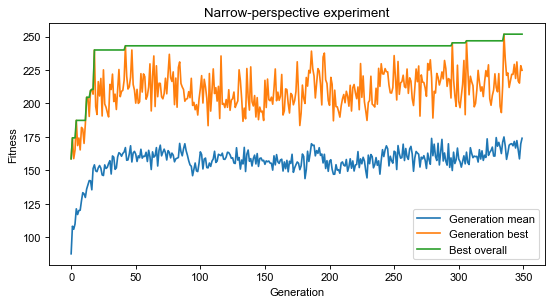

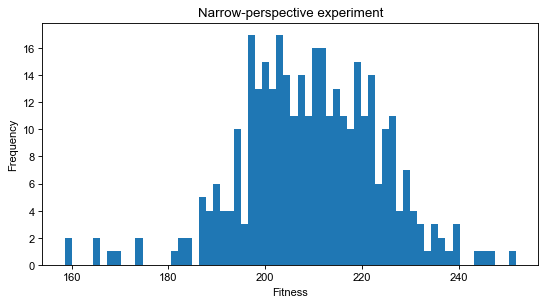

In [29]:
# plot fitness results

with open(filename, 'r') as f:
  data = np.loadtxt(f, delimiter='/', skiprows=1)

plt.rcParams["font.family"] = "Arial"
fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

line_mean, = plt.plot(data[:, 0], data[:, 1])
line_best_gen, = plt.plot(data[:, 0], data[:, 2])
line_best_overall, = plt.plot(data[:, 0], data[:, 3])
plt.legend([line_mean, line_best_gen, line_best_overall], ['Generation mean', 'Generation best', 'Best overall'], loc=4)


plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title(title)
plt.savefig(os.path.join(results_folder, dirname, name) + ".svg")

fig = plt.figure(figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
plt.title(title)
#plt.savefig(os.path.join(results_folder, dirname, name) + ".svg")

plt.hist(data[:, 2], density=False, bins=64) 
plt.ylabel('Frequency')
plt.xlabel('Fitness');

plt.show()

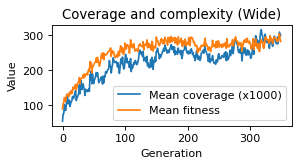

p:0.8652679987302891


In [36]:
# plot some individual statistics

with open(filename_ind, 'r') as f:
  data_ind = np.loadtxt(f, delimiter='/', skiprows=1)

df = pd.DataFrame(data=data_ind, columns=["gen", "id", "fitness", "coverage", "coverage_reward", "IC", "PC", "PCt0", "PCt1"])

df["PC"] = (df["PCt1"] - df["PCt0"])
df["coverage"] = df["coverage"]*1000.0

# grouped_df = df.groupby('gen').agg({
#     "coverage": [np.mean], 
#     "fitness": [np.mean],
#     "IC": [np.mean],
#     "PC": [np.mean]})

grouped_df = df.groupby('gen').agg({
    "coverage": [np.mean], 
    "fitness": [np.mean]
})

fig = plt.figure(figsize=(4, 2), dpi=80, facecolor='w', edgecolor='k', )
ax = plt.gca()
plt.gcf().subplots_adjust(bottom=0.25, left=0.15)

grouped_df.plot(kind='line', ax=ax)
ax.legend(["Mean coverage (x1000)", "Mean fitness"], loc=4);

plt.xlabel('Generation')
plt.ylabel('Value')
plt.title("Coverage and complexity (Wide)")

plt.savefig(os.path.join(results_folder, dirname, "narrow_cov_fitness_comp.svg"))
plt.show()

print("p: " , np.corrcoef(df["fitness"], df["coverage"])[1,0])

In [5]:
impath = os.path.join(exp_results_folder, 'artifacts')
imlist = os.listdir(impath)
dim = 8

list_im = [[ImageOps.expand(Image.open(os.path.join(impath, random.choice(imlist))), border=1, fill='black') for i in range(dim)]  for i in range(dim)]

imgs_arr = [np.vstack(list_im[i]) for i in range(dim)]
imgs_comb = [Image.fromarray(imgs_arr[i]) for i in range(dim)]
imgs_grid = Image.fromarray(np.hstack(imgs_comb))

#imgs_grid.save(os.path.join(results_folder, dirname, 'artifact_sample_grid.png')

In [10]:
with open(filename, 'r') as f:
  fitness_readout = np.loadtxt(f, delimiter='/', skiprows=1)
with open(filename_ind, 'r') as f:
  ind_fitness_readout = np.loadtxt(f, delimiter='/', skiprows=1)

font = ImageFont.load("arial.pil")

ids = []
for i in fitness_readout:
    gen, best = i[0], i[3]

    lis = np.array([x for x in ind_fitness_readout if x[0] == gen])
    result = f'{int(gen)}_{np.argmax(lis[:,2])}.jpg'
    ids.append(result)

ids = np.array(ids)[:64]
list_im = [[ImageOps.expand(Image.open(os.path.join(impath, ids[j+i*8])), border=1, fill='black') for i in range(8)] for j in range(8)]

for x in range(8):
    for y in range(8):
        draw = ImageDraw.Draw(list_im[x, y])

img = Image.open("sample_in.jpg")
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
font = ImageFont.truetype("sans-serif.ttf", 16)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((0, 0),"Sample Text",(255,255,255),font=font)
img.save('sample-out.jpg')


imgs_arr = [np.vstack(i) for i in list_im]
imgs_comb = [Image.fromarray(i) for i in imgs_arr]
imgs_grid = Image.fromarray(np.hstack(imgs_comb))

imgs_grid.save(os.path.join(results_folder, dirname, 'bestgrid.png'))

FileNotFoundError: [Errno 2] No such file or directory: 'arial.pil'